In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.projections import projection_registry

import project_fitness_function as fit

In [8]:
file = 'train_data.csv'
terreno_hectares = 2
limite_agua = 8.5
janela_dias = 90
orcamento_maximo = 7.5

interacoes = 250

In [9]:
df = pd.read_csv(file)

In [10]:
m2_area = terreno_hectares * 10_000

In [11]:
best_result = []
# Lista para armazenar os valores de fitness ao longo das iterações
fitness_history = []
# Lista para armazenar os valores médios de fitness ao longo das iterações
avg_fitness_history = []

def xpto(samples):
    results = []
    for i, sample in enumerate(samples):
        fit_result = fit.project_fitness_function(sample, orcamento_maximo, m2_area, limite_agua, janela_dias)
        results.append({'sample': sample, 'fitness': fit_result})

    results.sort(key=lambda x: x['fitness'],reverse=True)

    if len(best_result) == 0:
        best_result.append(results[0])

    if results[0]['fitness'] > best_result[0]['fitness']:
        best_result[0] = results[0]

    # Calcula a média de fitness desta iteração
    avg_fitness = sum(item['fitness'] for item in results) / len(results)
    # Adiciona à lista de médias
    avg_fitness_history.append(avg_fitness)

    # Retorna o melhor fitness desta iteração
    return results[0]['fitness']




# população inicial
initial_population = []

for i in range(100):
    initial_population.append(df.sample(3))

# executa para população inicial
initial_fitness = xpto(initial_population)
fitness_history.append(initial_fitness)

#crossover de genes
for i in range(interacoes):
    new_population = fit.crossover(initial_population,df)
    iteration_fitness = xpto(new_population)
    fitness_history.append(iteration_fitness)

    # Atualiza a população para a próxima iteração
    initial_population = new_population

print(best_result)



[{'sample':   CULTURA  CUSTO PRODUÇÃO  PRODUTIVIDADE  CICLO DE VIDA MIN EM DIAS  \
8   arroz             2.0            2.5                        110   
2    café             3.0            2.0                       1096   
9   trigo             2.0            2.0                        100   

   CICLO DE VIDA MAX EM DIAS  REQUISITO DE ÁGUA  RETORNO FINANCEIRO SINERGIA  \
8                        150                3.0                 2.0  nenhuma   
2                       1461                3.0                 3.0   feijão   
9                        130                2.0                 2.0     soja   

    COMPANHEIRA          NEUTRA               ANTAGÔNICA  ESPAÇO MÍNIMO m²  
8   trigo,aveia      milho,soja     sorgo,cana-de-açúcar              0.20  
2  milho,banana  mandioca,arroz      soja,cana-de-açúcar              2.50  
9   arroz,aveia    milho,feijão  mandioca,cana-de-açúcar              0.15  , 'fitness': 63.497405672279264}]


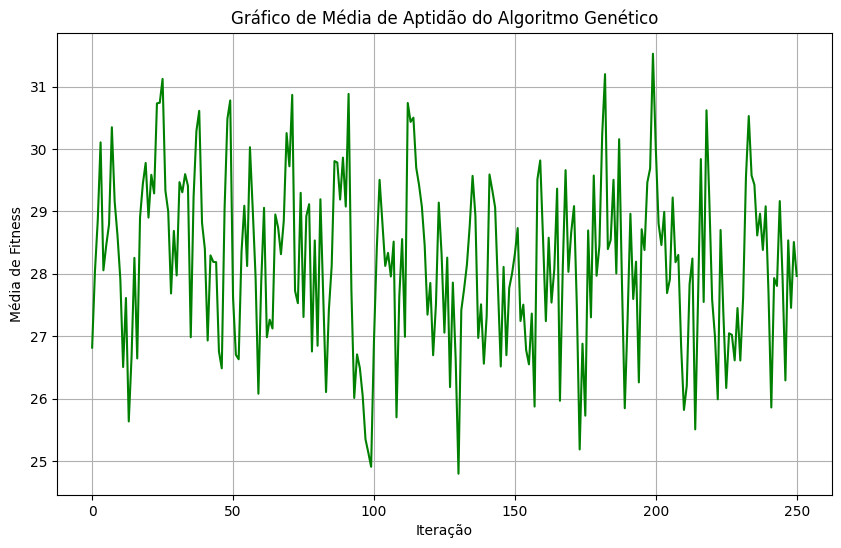

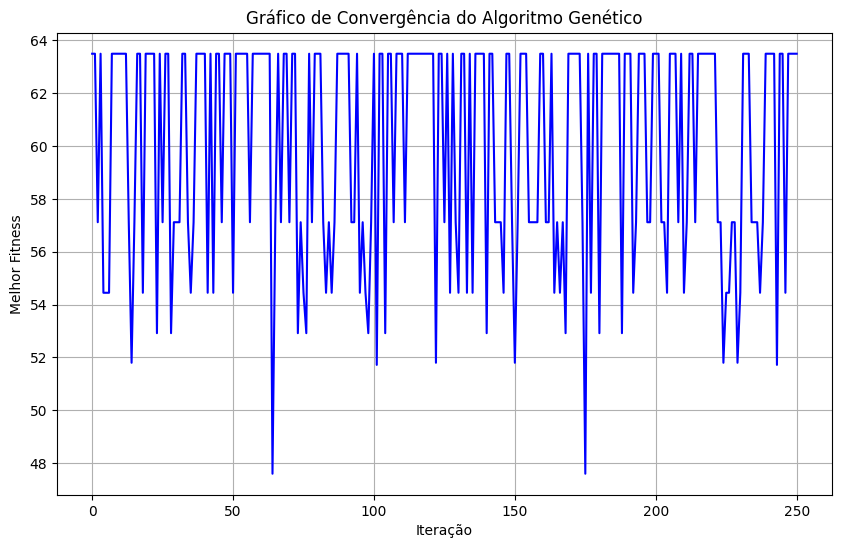

In [12]:



# Plotar o gráfico de média de aptidão
plt.figure(figsize=(10, 6))
plt.plot(range(len(avg_fitness_history)), avg_fitness_history, linestyle='-', color='g')
plt.title('Gráfico de Média de Aptidão do Algoritmo Genético')
plt.xlabel('Iteração')
plt.ylabel('Média de Fitness')
plt.grid(True)
plt.show()

# Plotar o gráfico de convergência
plt.figure(figsize=(10, 6))
plt.plot(range(len(fitness_history)), fitness_history, linestyle='-', color='b')
plt.title('Gráfico de Convergência do Algoritmo Genético')
plt.xlabel('Iteração')
plt.ylabel('Melhor Fitness')
plt.grid(True)
plt.show()
